<a href="https://colab.research.google.com/github/mehrshad98/UrbanFloodPredictor/blob/main/DL_Mershad'sDraft_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of CNN-Classifier Report

##Set Up Environment and Import Libraries

In [ ]:
!pip install tensorflow==2.17.0 keras==3.4.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 932.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
 

In [ ]:
import os
import random

from shutil import copyfile
from shutil import move

# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0


In [ ]:

# Print the versions to ensure everything is correct
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


##Load and Pre-process Data
We will load the data and split it for training, validation, and testing as the previous project did (80% training, 20% validation).

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL HOMEWORK 1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1


In [ ]:
# Load the dataset
data = np.load('training_set.npz')  # Replace with correct path
X = data['images']
y = data['labels']

# Print the shapes to verify
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)


In [ ]:

# Ensure y is in integer label format (not one-hot encoded)
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

# Normalize images
X = X / 255.0

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=SEED)


##Oversampling Minority Classes Using SMOTE

In [ ]:
# Flatten images for SMOTE
n_samples, width, height, channels = X_train.shape
X_train_flat = X_train.reshape((n_samples, width * height * channels))

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape X back to original shape
X_resampled = X_resampled_flat.reshape((X_resampled_flat.shape[0], width, height, channels))

# --- Step 2: Define Class Weights for Training ---

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_resampled),
                                     y=y_resampled)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


## Data Augmentation
As in the original work, use traditional data augmentations such as rotation, zoom, and flips.

In [ ]:
# Set up the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,            # Random rotations up to 20 degrees
    width_shift_range=0.2,        # Random horizontal shifts
    height_shift_range=0.2,       # Random vertical shifts
    shear_range=0.15,             # Shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flipping
    fill_mode='nearest'           # Fill mode for transformations
)

# Fit the data generator to the training set
datagen.fit(X_resampled)


##Model Architecture Setup (Feature Extractor)
Use EfficientNetB0 as the feature extractor with Global Average Pooling and a classifier layer on top. Follow the approach from the report by adding specific layers such as Batch Normalization and ReLU activation.

In [ ]:
# Using EfficientNetB0 as the feature extractor
input_shape = (X.shape[1], X.shape[2], X.shape[3])  # Make input shape dynamic based on actual data
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model layers initially

# Define the model architecture
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_initializer='glorot_uniform',
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)                      # Add a Dense layer with 256 neurons
x = BatchNormalization()(x)            # Batch Normalization layer for regularization
x = Activation('relu')(x)              # Use ReLU activation
x = Dropout(0.2)(x)                    # Dropout layer for regularization, 0.2 rate
outputs = Dense(8, activation='softmax', kernel_initializer='glorot_uniform')(x)  # 8 output classes for blood cells

model = Model(inputs, outputs)

# Compile the model using standard loss to avoid TensorFlow Addons dependency
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,587 (16.71 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

## Initial Training (Transfer Learning)
Initially, train the custom top layers while keeping the EfficientNetB0 layers frozen.

In [ ]:
batch_size = 32

history = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,  # Train for a few epochs
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,  # Use calculated class weights
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


505/505 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - accuracy: 0.1261 - loss: 3.9219 - val_accuracy: 0.0749 - val_loss: 2.7773
Epoch 2/20
  1/505 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.1250 - loss: 2.2766

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.2766 - val_accuracy: 0.0749 - val_loss: 2.8107
Epoch 3/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1336 - loss: 2.2817 - val_accuracy: 0.0749 - val_loss: 2.8436
Epoch 4/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0312 - loss: 2.2075 - val_accuracy: 0.0749 - val_loss: 2.9246
Epoch 5/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.1264 - loss: 2.1967 - val_accuracy: 0.1733 - val_loss: 2.2954
Epoch 6/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.1294 - val_accuracy: 0.1733 - val_loss: 2.2786
Epoch 7/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1253 - loss: 2.1574 - val_accuracy: 0.1377 - val_loss: 2.6224
Epoch 8/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1562 - loss: 2.1010 - val_accuracy: 0.1432 - val_loss: 2.5982
Epoch 9/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1249 - loss: 2.1321 - val_accurac

##Fine-Tuning the Model
Unfreeze the EfficientNetB0 base layers and fine-tune the entire model with a lower learning rate.

In [ ]:

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the entire model
history_finetune = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

Epoch 1/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 78s 128ms/step - accuracy: 0.1241 - loss: 2.0941 - val_accuracy: 0.0970 - val_loss: 2.0970
Epoch 2/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0625 - loss: 2.1204 - val_accuracy: 0.0970 - val_loss: 2.0969
Epoch 3/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 60s 119ms/step - accuracy: 0.1266 - loss: 2.0910 - val_accuracy: 0.0970 - val_loss: 2.0924
Epoch 4/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0625 - loss: 2.0961 - val_accuracy: 0.0970 - val_loss: 2.0924
Epoch 5/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 61s 120ms/step - accuracy: 0.1347 - loss: 2.0884 - val_accuracy: 0.1083 - val_loss: 2.0890
Epoch 6/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0312 - loss: 2.0901 - val_accuracy: 0.1083 - val_loss: 2.0890
Epoch 7/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 61s 119ms/step - accuracy: 0.1298 - loss: 2.0887 - val_accuracy: 0.1850 - val_loss: 2.0840
Epoch 8/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.0883 - 

##Plot Training Results
Replicate the performance evaluation plot as per the report to visualize training and validation losses and accuracies.

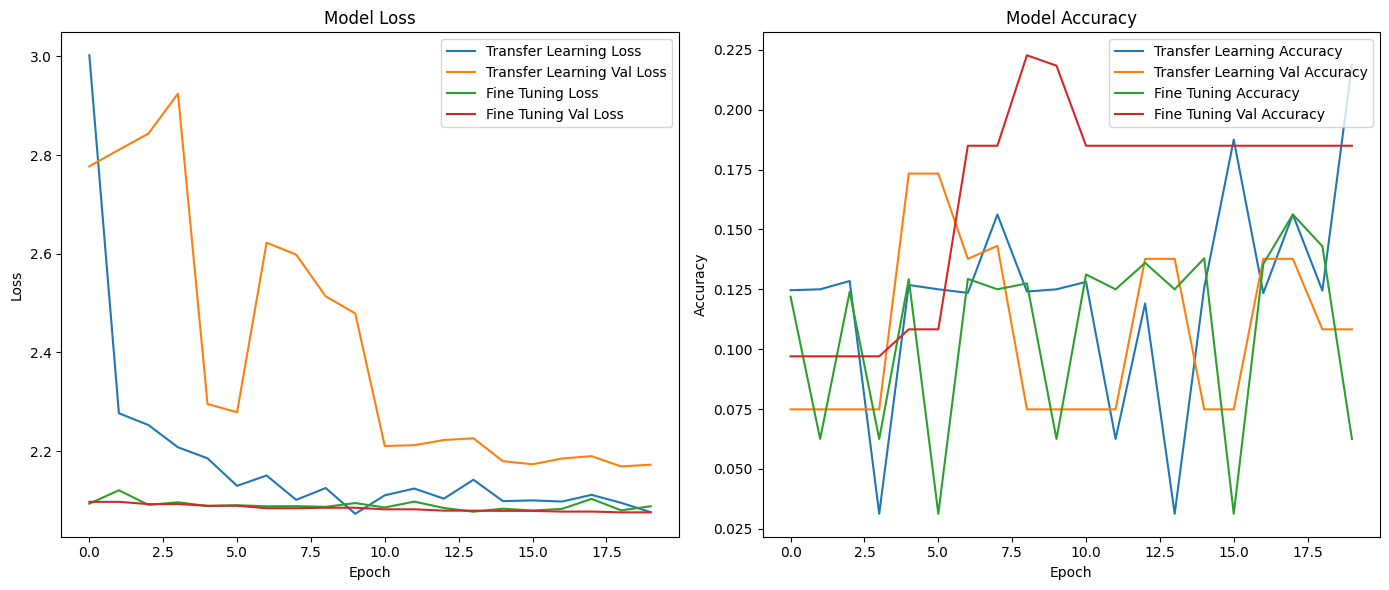

In [ ]:
# Plot the training history
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Transfer Learning Loss')
plt.plot(history.history['val_loss'], label='Transfer Learning Val Loss')
plt.plot(history_finetune.history['loss'], label='Fine Tuning Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine Tuning Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Transfer Learning Accuracy')
plt.plot(history.history['val_accuracy'], label='Transfer Learning Val Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine Tuning Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine Tuning Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##Evaluate and Save the Model
Evaluate the model on the validation set and save it for further testing.

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.1919 - loss: 2.0752
Validation Loss: 2.0756547451019287
Validation Accuracy: 0.1849564015865326


###Generate Predictions and Plot Confusion Matrix
First, we need to predict the labels for the validation set. Then, we will create the confusion matrix using sklearn.metrics.confusion_matrix and visualize it with matplotlib.

86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.00      0.00      0.00       477
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00       409
           4       0.00      0.00      0.00       206
           5       0.00      0.00      0.00       298
           6       0.18      1.00      0.31       509
           7       0.00      0.00      0.00       379

    accuracy                           0.18      2752
   macro avg       0.02      0.12      0.04      2752
weighted avg       0.03      0.18      0.06      2752



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


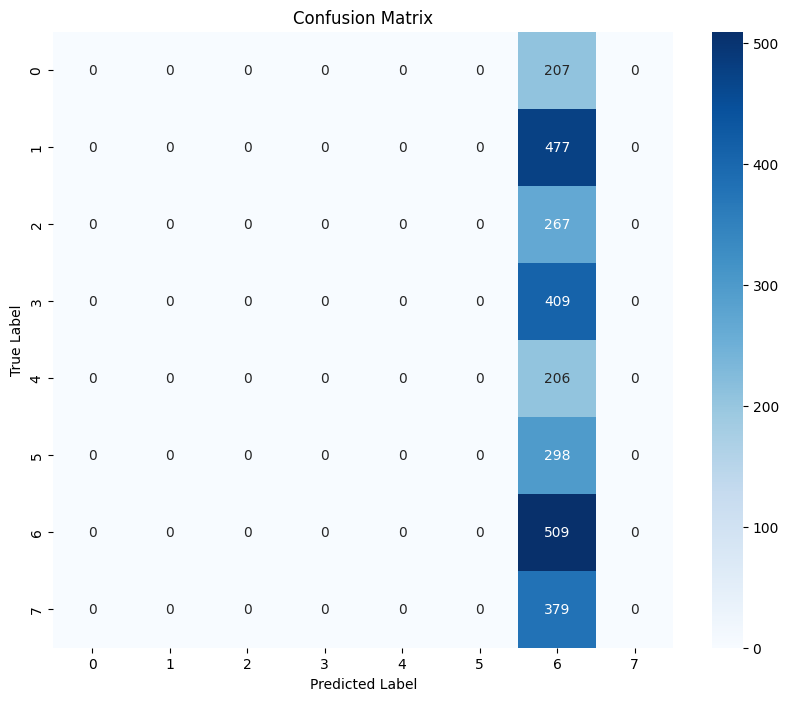

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print('Classification Report:')
print(classification_report(y_val, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:

# Save the trained model
model.save("blood_cell_effnetB0_finetuned_model.keras")


#V 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1
Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


505/505 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.1224 - loss: 2.1412 - val_accuracy: 0.0749 - val_loss: 2.1229
Epoch 2/20
  1/505 ━━━━━━━━━━━━━━━━━━━━ 1:19 159ms/step - accuracy: 0.0625 - loss: 2.1301

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0625 - loss: 2.1301 - val_accuracy: 0.0749 - val_loss: 2.1221
Epoch 3/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 172ms/step - accuracy: 0.1220 - loss: 2.0990 - val_accuracy: 0.2656 - val_loss: 2.0750
Epoch 4/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0938 - loss: 2.0778 - val_accuracy: 0.2660 - val_loss: 2.0759
Epoch 5/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 171ms/step - accuracy: 0.1221 - loss: 2.0918 - val_accuracy: 0.0752 - val_loss: 2.0915
Epoch 6/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.1074 - val_accuracy: 0.0752 - val_loss: 2.0916
Epoch 7/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 88s 173ms/step - accuracy: 0.1214 - loss: 2.0871 - val_accuracy: 0.0752 - val_loss: 2.0860
Epoch 8/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.0577 - val_accuracy: 0.0752 - val_loss: 2.0855
Epoch 9/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 87s 171ms/step - accuracy: 0.1293 - loss: 2.0847 - val_accurac

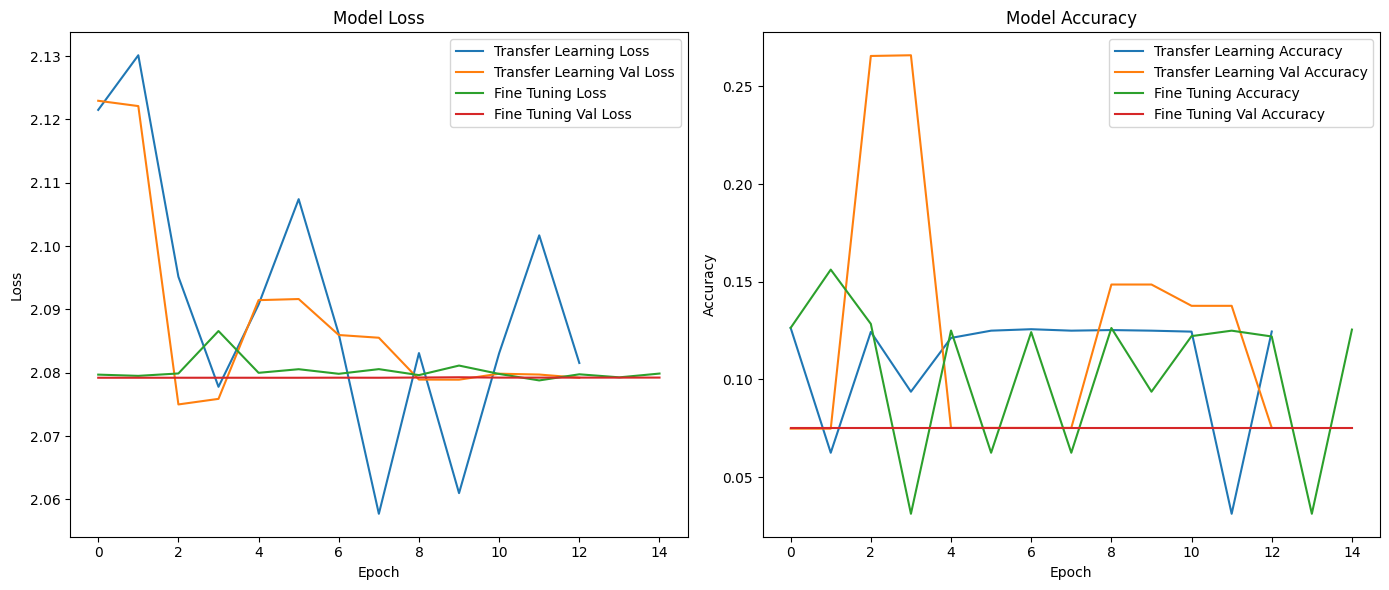

86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.08      1.00      0.14       207
           1       0.00      0.00      0.00       477
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00       409
           4       0.00      0.00      0.00       206
           5       0.00      0.00      0.00       298
           6       0.00      0.00      0.00       509
           7       0.00      0.00      0.00       379

    accuracy                           0.08      2752
   macro avg       0.01      0.12      0.02      2752
weighted avg       0.01      0.08      0.01      2752



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


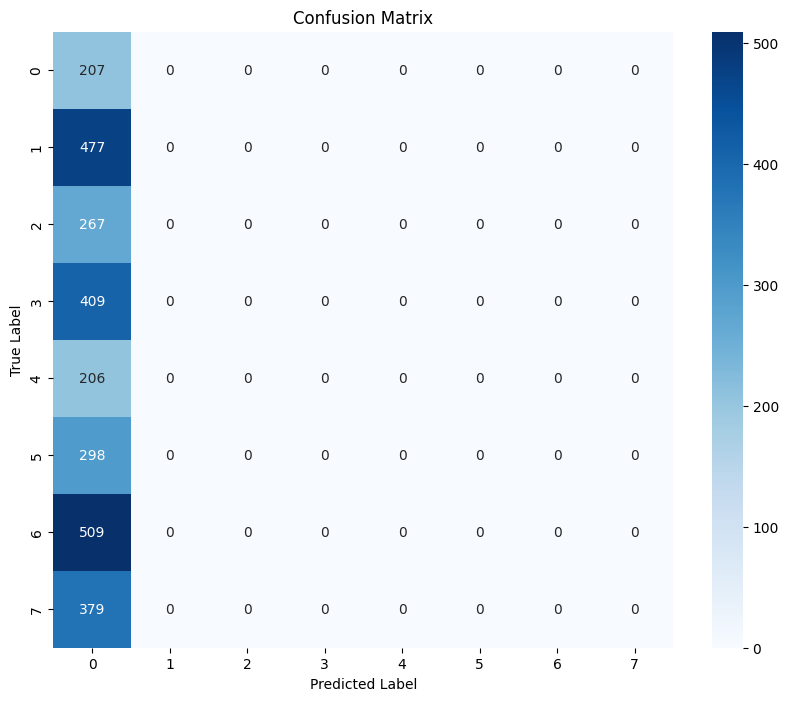

In [ ]:
# Import necessary libraries
!pip install imbalanced-learn
!pip install tensorflow

import os
import random

from shutil import copyfile
from shutil import move

# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

import numpy as np
from sklearn.model_selection import train_test_split
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the dataset

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL HOMEWORK 1

data = np.load('training_set.npz')  # Replace with correct path
X = data['images']
y = data['labels']

# Print the shapes to verify
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Ensure y is in integer label format (not one-hot encoded)
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

# Normalize images
X = X / 255.0

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# --- Step 1: Oversampling Minority Classes Using SMOTE ---

# Flatten images for SMOTE
n_samples, width, height, channels = X_train.shape
X_train_flat = X_train.reshape((n_samples, width * height * channels))

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape X back to original shape
X_resampled = X_resampled_flat.reshape((X_resampled_flat.shape[0], width, height, channels))

# --- Step 2: Define Class Weights for Training ---

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Step 3: Data Augmentation ---

# Set up the data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,            # Random rotations up to 30 degrees for more aggressive augmentation
    width_shift_range=0.2,        # Random horizontal shifts
    height_shift_range=0.2,       # Random vertical shifts
    shear_range=0.15,             # Shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flipping
    vertical_flip=True,          # Random vertical flipping for more variation
    brightness_range=[0.8, 1.2],  # Random brightness adjustment for enhanced diversity
    fill_mode='nearest'           # Fill mode for transformations
)

# Fit the data generator to the training set
datagen.fit(X_resampled)

# --- Step 4: Model Architecture Setup ---

# Using EfficientNetB0 as the feature extractor
input_shape = (X.shape[1], X.shape[2], X.shape[3])  # Make input shape dynamic based on actual data
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers[:-100]:  # Freeze all but the last 100 layers initially
    layer.trainable = False

# Define the model architecture
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)

# Split into two different heads for ensemble within the model
x1 = GlobalAveragePooling2D()(x)
x1 = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(x1)
x1 = Dropout(0.3)(x1)

x2 = GlobalAveragePooling2D()(x)
x2 = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(x2)
x2 = Dropout(0.3)(x2)

# Concatenate both heads
total_output = tf.keras.layers.Concatenate()([x1, x2])
x = GlobalAveragePooling2D()(x)
x = Dense(128, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = Activation('relu')(x)  # Add ReLU activation for additional complexity
x = Dense(64, kernel_initializer='glorot_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)  # Add another Dense layer for better representation                      # Add a Dense layer with 256 neurons
x = BatchNormalization()(x)            # Batch Normalization layer for regularization
x = Activation('relu')(x)              # Use ReLU activation
x = Dropout(0.2)(x)                    # Dropout layer for regularization, 0.2 rate
outputs = Dense(8, activation='softmax', kernel_initializer='glorot_uniform')(total_output)  # 8 output classes for blood cells

model = Model(inputs, outputs)

# Display model summary to see the architecture
model.summary()

# Compile the model using standard loss to avoid TensorFlow Addons dependency
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use a lower learning rate to stabilize training

# --- Step 5: Initial Training (Transfer Learning) ---

batch_size = 32

history = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,  # Train for a few epochs
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,  # Use calculated class weights
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

# --- Step 6: Fine-Tuning the Model ---

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-100:]:  # Unfreeze the last 100 layers to help with fine-tuning
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the entire model
history_finetune = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

# --- Step 7: Plot Training Results ---

# Plot the training history
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Transfer Learning Loss')
plt.plot(history.history['val_loss'], label='Transfer Learning Val Loss')
plt.plot(history_finetune.history['loss'], label='Fine Tuning Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine Tuning Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Transfer Learning Accuracy')
plt.plot(history.history['val_accuracy'], label='Transfer Learning Val Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine Tuning Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine Tuning Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- Step 8: Model Evaluation ---

# Predict validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print('Classification Report:')
print(classification_report(y_val, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#V3

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1
Images shape: (13759, 96, 96, 3)
Labels shape: (13759, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,587 (16.71 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


505/505 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - accuracy: 0.1244 - loss: 2.2412 - val_accuracy: 0.0749 - val_loss: 2.2083
Epoch 2/20
  1/505 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.1250 - loss: 2.2541

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1250 - loss: 2.2541 - val_accuracy: 0.0749 - val_loss: 2.2055
Epoch 3/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1327 - loss: 2.1758 - val_accuracy: 0.1733 - val_loss: 2.5447
Epoch 4/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1562 - loss: 2.0270 - val_accuracy: 0.1733 - val_loss: 2.5445
Epoch 5/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.1334 - loss: 2.1625 - val_accuracy: 0.0752 - val_loss: 2.3298
Epoch 6/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0938 - loss: 2.1462 - val_accuracy: 0.0752 - val_loss: 2.3560
Epoch 7/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 113ms/step - accuracy: 0.1351 - loss: 2.1442 - val_accuracy: 0.1850 - val_loss: 2.1833
Epoch 8/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0938 - loss: 2.1103 - val_accuracy: 0.1850 - val_loss: 2.1763
Epoch 9/20
505/505 ━━━━━━━━━━━━━━━━━━━━ 58s 114ms/step - accuracy: 0.1337 - loss: 2.1341 - val_accurac

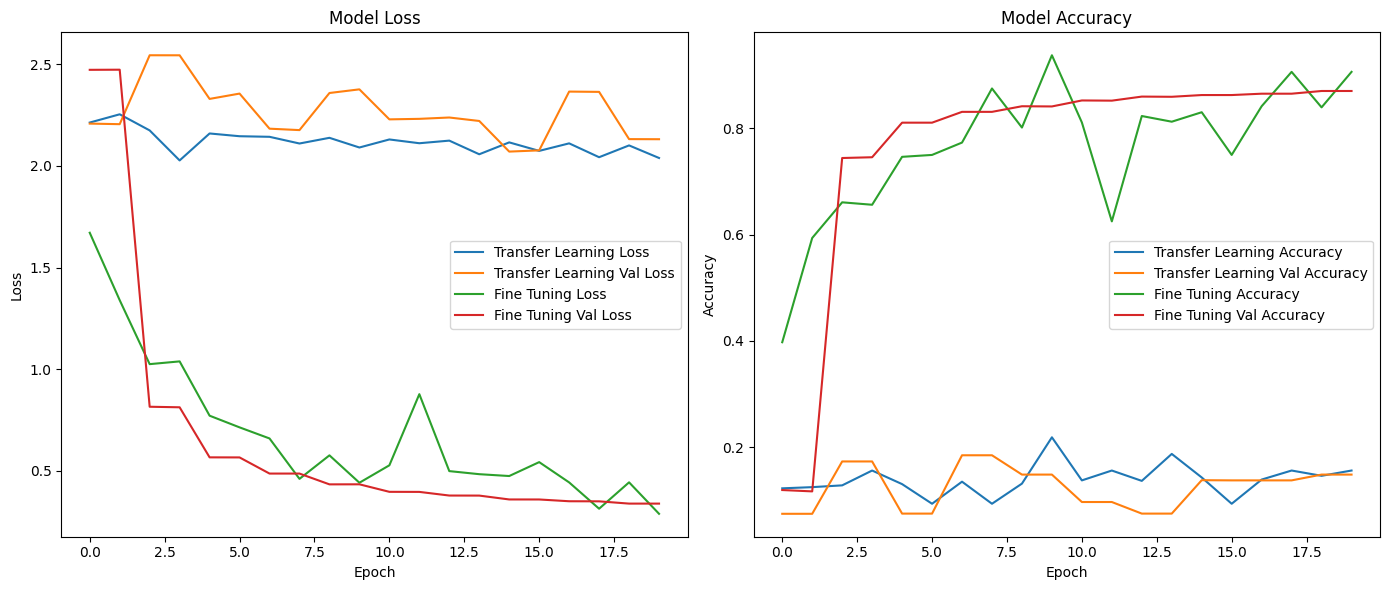

86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       207
           1       1.00      0.90      0.95       477
           2       0.99      0.81      0.89       267
           3       0.89      0.85      0.87       409
           4       0.41      0.93      0.57       206
           5       0.92      0.85      0.89       298
           6       0.98      0.90      0.94       509
           7       1.00      0.89      0.94       379

    accuracy                           0.87      2752
   macro avg       0.89      0.86      0.86      2752
weighted avg       0.92      0.87      0.89      2752



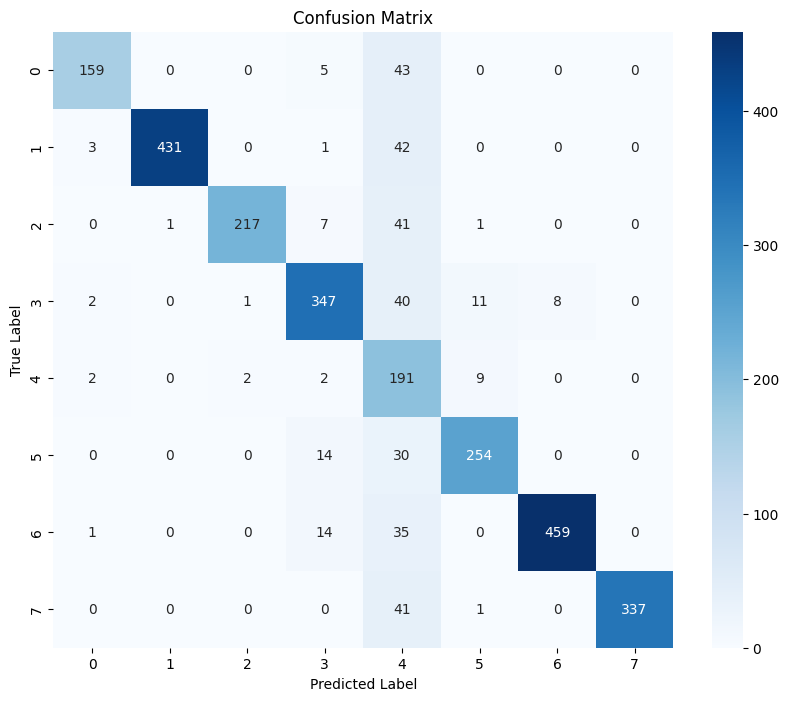

In [ ]:
# Import necessary libraries
!pip install imbalanced-learn
!pip install tensorflow

import os
import random

from shutil import copyfile
from shutil import move

# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

import numpy as np
from sklearn.model_selection import train_test_split
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the dataset

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL HOMEWORK 1

data = np.load('training_set.npz')  # Replace with correct path
X = data['images']
y = data['labels']

# Print the shapes to verify
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Ensure y is in integer label format (not one-hot encoded)
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

# Normalize images
X = X / 255.0

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# --- Step 1: Oversampling Minority Classes Using SMOTE ---

# Flatten images for SMOTE
n_samples, width, height, channels = X_train.shape
X_train_flat = X_train.reshape((n_samples, width * height * channels))

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape X back to original shape
X_resampled = X_resampled_flat.reshape((X_resampled_flat.shape[0], width, height, channels))

# --- Step 2: Define Class Weights for Training ---

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- Step 3: Data Augmentation ---

# Set up the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,            # Random rotations up to 20 degrees
    width_shift_range=0.2,        # Random horizontal shifts
    height_shift_range=0.2,       # Random vertical shifts
    shear_range=0.15,             # Shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flipping
    fill_mode='nearest'           # Fill mode for transformations
)

# Fit the data generator to the training set
datagen.fit(X_resampled)

# --- Step 4: Model Architecture Setup ---

# Using EfficientNetB0 as the feature extractor
input_shape = (X.shape[1], X.shape[2], X.shape[3])  # Make input shape dynamic based on actual data
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model layers initially

# Define the model architecture
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_initializer='glorot_uniform')(x)  # Add a Dense layer with 256 neurons
x = BatchNormalization()(x)  # Batch Normalization layer for regularization
x = Activation('relu')(x)  # Use ReLU activation
x = Dropout(0.3)(x)  # Dropout layer for regularization, 0.3 rate
outputs = Dense(8, activation='softmax', kernel_initializer='glorot_uniform')(x)  # 8 output classes for blood cells

model = Model(inputs, outputs)

# Display model summary to see the architecture
model.summary()

# Compile the model using standard loss to avoid TensorFlow Addons dependency
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Use a lower learning rate to stabilize training

# --- Step 5: Initial Training (Transfer Learning) ---

batch_size = 32

history = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,  # Train for a few epochs
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,  # Use calculated class weights
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

# --- Step 6: Fine-Tuning the Model ---

# Unfreeze the entire base model for fine-tuning
base_model.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the entire model
history_finetune = model.fit(
    datagen.flow(X_resampled, y_resampled, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_resampled) // batch_size,
    class_weight=class_weights_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

# --- Step 7: Plot Training Results ---

# Plot the training history
plt.figure(figsize=(14, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Transfer Learning Loss')
plt.plot(history.history['val_loss'], label='Transfer Learning Val Loss')
plt.plot(history_finetune.history['loss'], label='Fine Tuning Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine Tuning Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Transfer Learning Accuracy')
plt.plot(history.history['val_accuracy'], label='Transfer Learning Val Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine Tuning Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine Tuning Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- Step 8: Model Evaluation ---

# Predict validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print('Classification Report:')
print(classification_report(y_val, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
